In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import namedtuple
from random import random
import sys
sys.path.append('../')

In [2]:
from MCTS import MCTS
from Node import Node
from Game import Connect4
from ReplayMemory import ReplayMemory

In [3]:
# Declare NN of policy:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        
        self.l1 = nn.Linear(42, 20)
        self.l2 = nn.Linear(20, 7)
        self.l3 = nn.Linear(20,1)
        self.sm = nn.Softmax(dim=0)
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        x = F.relu(self.l1(x.view(-1)))
        x1 = self.l2(x) # Logit value of policy
        x1 = self.sm(x1)
        x2 = torch.tanh(self.l3(x)) # Value head.
        return x1, x2

In [4]:
#MCTS game:
T = 0.3
state = torch.zeros(6,7, dtype=torch.float)
end = False
player = -1

dnn = DNN()
game = Connect4()
root = Node(state, 1, player)
mcts = MCTS(game, root, dnn, ngames=200)

node = root
while not end:
    mcts.explore(node)
    a = mcts.play(node, T)
    node = node.children[a]
    game.plot(node.state)
    
    end, winner = game.check_end(node.state)

-----------------------------
|   |   |   |   |   |   |   | 
-----------------------------
|   |   |   |   |   |   |   | 
-----------------------------
|   |   |   |   |   |   |   | 
-----------------------------
|   |   |   |   |   |   |   | 
-----------------------------
|   |   |   |   |   |   |   | 
-----------------------------
|   |   |   |   | x |   |   | 
-----------------------------
-----------------------------
|   |   |   |   |   |   |   | 
-----------------------------
|   |   |   |   |   |   |   | 
-----------------------------
|   |   |   |   |   |   |   | 
-----------------------------
|   |   |   |   |   |   |   | 
-----------------------------
|   |   |   |   | o |   |   | 
-----------------------------
|   |   |   |   | x |   |   | 
-----------------------------
-----------------------------
|   |   |   |   |   |   |   | 
-----------------------------
|   |   |   |   |   |   |   | 
-----------------------------
|   |   |   |   |   |   |   | 
-------------------------

# Train loop

In [5]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [6]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

def loss_plot(loss):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    loss = np.array(loss)
    plt.plot(loss[:,0], loss[:,1])

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.display(plt.gcf())
        display.clear_output(wait=True)

In [7]:
CAPACITY = 5000
REPLAY_START_SIZE = 100
BATCH = 100

EPISODES = 1000

NGAMES=200

In [8]:
Transition = namedtuple('Transition',('state', 'policy', 'reward'))

In [9]:
dnn = DNN()
replay_memory = ReplayMemory(CAPACITY)

In [10]:
def loss_fn(z, v, policy, net_pol):
    a = torch.mean(torch.pow(z-v,2))
    b = (policy * torch.log(net_pol)).sum()
    return a - b

In [11]:
optimizer = torch.optim.SGD(dnn.parameters(), lr=1e-2, weight_decay=1e-4)

In [12]:
def optimize(model, optimizer, loss_fn, memory):
    if memory.__len__() < REPLAY_START_SIZE:
        return
    
    transitions = memory.sample(BATCH)
    batch = Transition(*zip(*transitions))
    
    states = torch.cat(batch.state).reshape([BATCH,-1])
    policy = torch.cat(batch.policy).reshape([BATCH,-1])
    z = torch.cat(batch.reward).reshape([BATCH,-1])
    
    net_pol, v = dnn(states)
    
    
    loss = loss_fn(z,v,policy,net_pol)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.data.item()

In [15]:
# Train loop:
def play_game():
    T = 0.3
    state = torch.tensor([0,0,0,0,0,0,0,0,0],dtype=torch.float)
    end = False
    player = -1
    
    
    game = Connect4()
    root = Node(state, 1, player)
    mcts = MCTS(game, root, dnn, ngames=NGAMES)
    
    node = root
    
    history = []
    while not end:
        history.append(node)
        mcts.explore(node)
        a = mcts.play(node, T)
        node = node.children[a]
        
        end, winner = game.check_end(node.state)
    
    # Save play in replaymemory
    for node in history:
        policy = torch.tensor([0,0,0,0,0,0,0,0,0],dtype=torch.float)
        p = mcts.eval_policy(node, 1)
        for i, a in enumerate(game.avail_actions(node.state)):
            policy[a] = p[i]
            
        replay_memory.add(node.state, policy, torch.tensor([-winner*node.player], dtype=torch.float))
        
    return winner

IndexError: too many indices for tensor of dimension 1

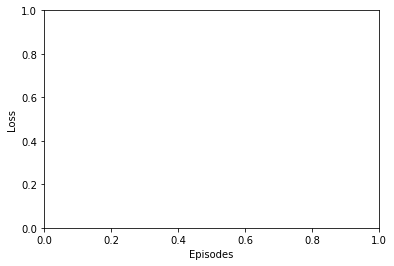

In [16]:
loss_hist = []
winner = []
fig, ax = plt.subplots(1,1)
ax.set_xlabel('Episodes')
ax.set_ylabel('Loss')

plt.ion()
for episode in range(EPISODES):
    # Play game to fill memory
    w = play_game()
    winner.append([episode, w])
    
    # Optimize
    for iopt in range(20):
        loss = optimize(dnn, optimizer, loss_fn, replay_memory)
    loss_hist.append([episode, loss])
    
    if len(winner) > 10:
        win_prob = sum(w[1] for w in winner[-10:]) / len(winner[-10:])
        print('Win mean:', win_prob)
    print('Loss:', loss)
    loss_plot(loss_hist)
    
plt.ioff()

In [ ]:
 Save model to file:
torch.save(dnn.state_dict(), './TicTacToe_Agent.pth')

In [ ]:
loss_hist = np.array(loss_hist)
winner_hist = np.array(winner)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(loss_hist[:,0], loss_hist[:,1])
ax[1].plot(winner_hist[:,0], winner_hist[:,1])

ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Loss')


ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Win mean')

plt.savefig('loss_wins.png',bbox_inches='tight')
plt.show()

In [ ]:
#Test:
state = torch.tensor([ 1., -1.,  1., -1., 1.,  1,  0.,  -1.,  0.],dtype=torch.float)
end = False
player = 1

game = TicTacToe_Board()
root = Node(state, 1, player)
mcts = MCTS(game, root, dnn)

game.plot(state)
node = root
# Expand state:
mcts.player *= -1
actions = game.avail_actions(node.state)
mcts.expand(node, actions)
a = torch.argmax(torch.tensor([child.P for child in node.children]))
node = node.children[a]
game.plot(node.state)
print(node.state)

In [7]:
for i in range(3,0,-1):
    print(i)

3
2
1
